Hunter Bennett | Glass Lab | Brain Aging Project | 19 Feb 2021

This notebook assesses some unbiased metrics of sample quality and sample clustering, with the goal of filtering outlier samples that could not be determined outliers based on the QC metrics alone in earlier notebooks. We use a number of plots to do this.
1. Mean-variance scatters across all peaks. This can help assess how unbalanced the samples are based on the mean tag counts in peaks and the variance in peak tag counts, generally similar levels in mean tag counts are preferred.
2. Correlation clustermaps - this assesses how well the peak values correlate across pairwise samples.
3. Principal component analysis - this is probably the most useful step as it helps see whether there are outlier samples whose differences are stronger than the differences associated with our variables of interest.
____
After running these three analyses the user can select samples to filter and run the analysis again to see if clustering is improved. Following filtration this notebook also generates merged tag directories with the final set of samples and creates a UCSC broswer hub for visualization of merged tag directories. Lastly, pairwise scatters of average peaks are compared prior to visualization with DESeq2 in the next notebook

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

### Set working paths

In [3]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/NeuN/'
workingDirectory = '/home/h1bennet/brain_aging/results/01_NeuN_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Read in annotation files

In [6]:
# import annotation file
df, mat = read_annotated_peaks('./annotated_peaks/ann_norm_vw_peaks_merged.txt')

# # try with dropped sample
# dropsamp = ['00_mouse_BL6_M_8week_PU1_ChIP_H3K27Ac_3_AL_20191226_GTAGAG_ds']

# df = df.drop(dropsamp, axis=1)
# mat = mat.drop(dropsamp, axis=1)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

## Filter low tag peaks

In [8]:
thresh = 16

print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
mat = mat.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

75485 total peaks
filtering low tag count peaks
65070 total peaks


# Make summary plots

In [1]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures/')

NameError: name 'os' is not defined

## Mean variance plot

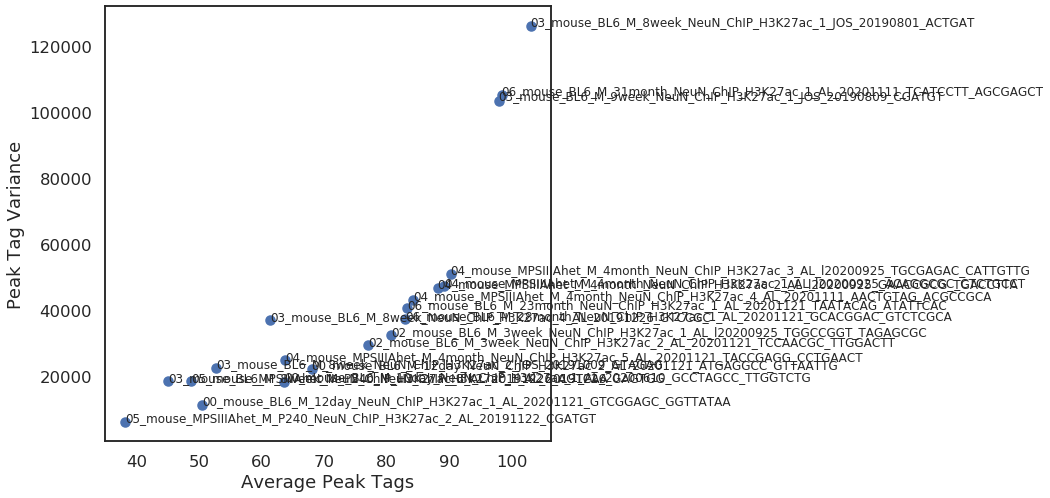

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png', bbox_inches='tight')

### Try with quantile normalized data

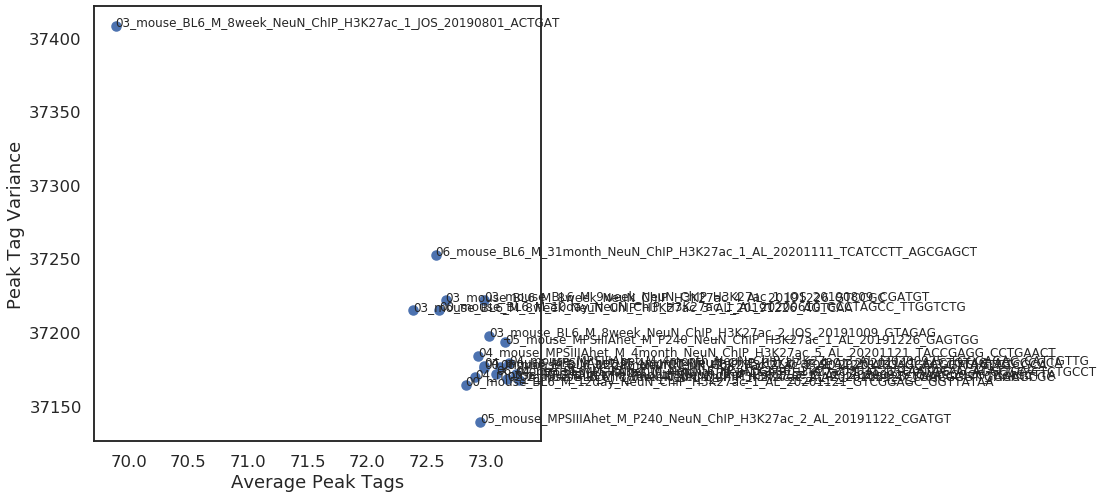

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png', bbox_inches='tight')

## Correlation heatmap

In [11]:
mat.columns = mat.columns.str.split('/').str[-1]
mat_quant.columns = mat_quant.columns.str.split('/').str[-1]
mat_distal.columns = mat_distal.columns.str.split('/').str[-1]

### Normalized data, all peaks

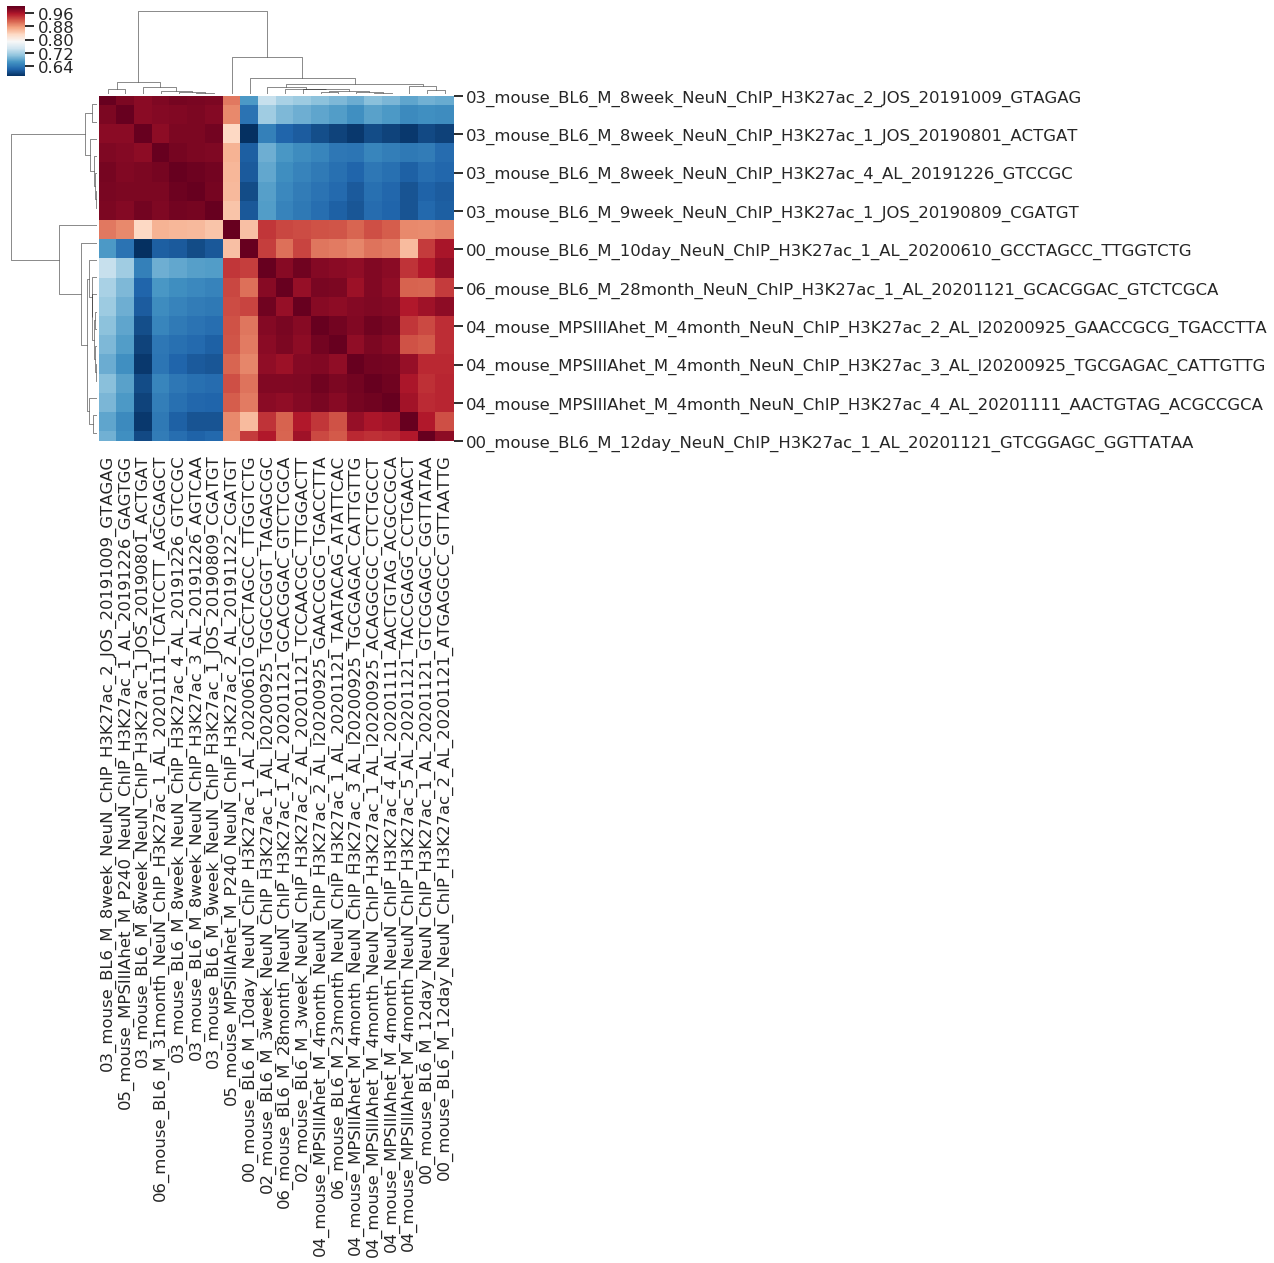

In [12]:
cm = sns.clustermap(
    mat.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap.png', bbox_inches='tight')

### Quantile normalized data - all peaks

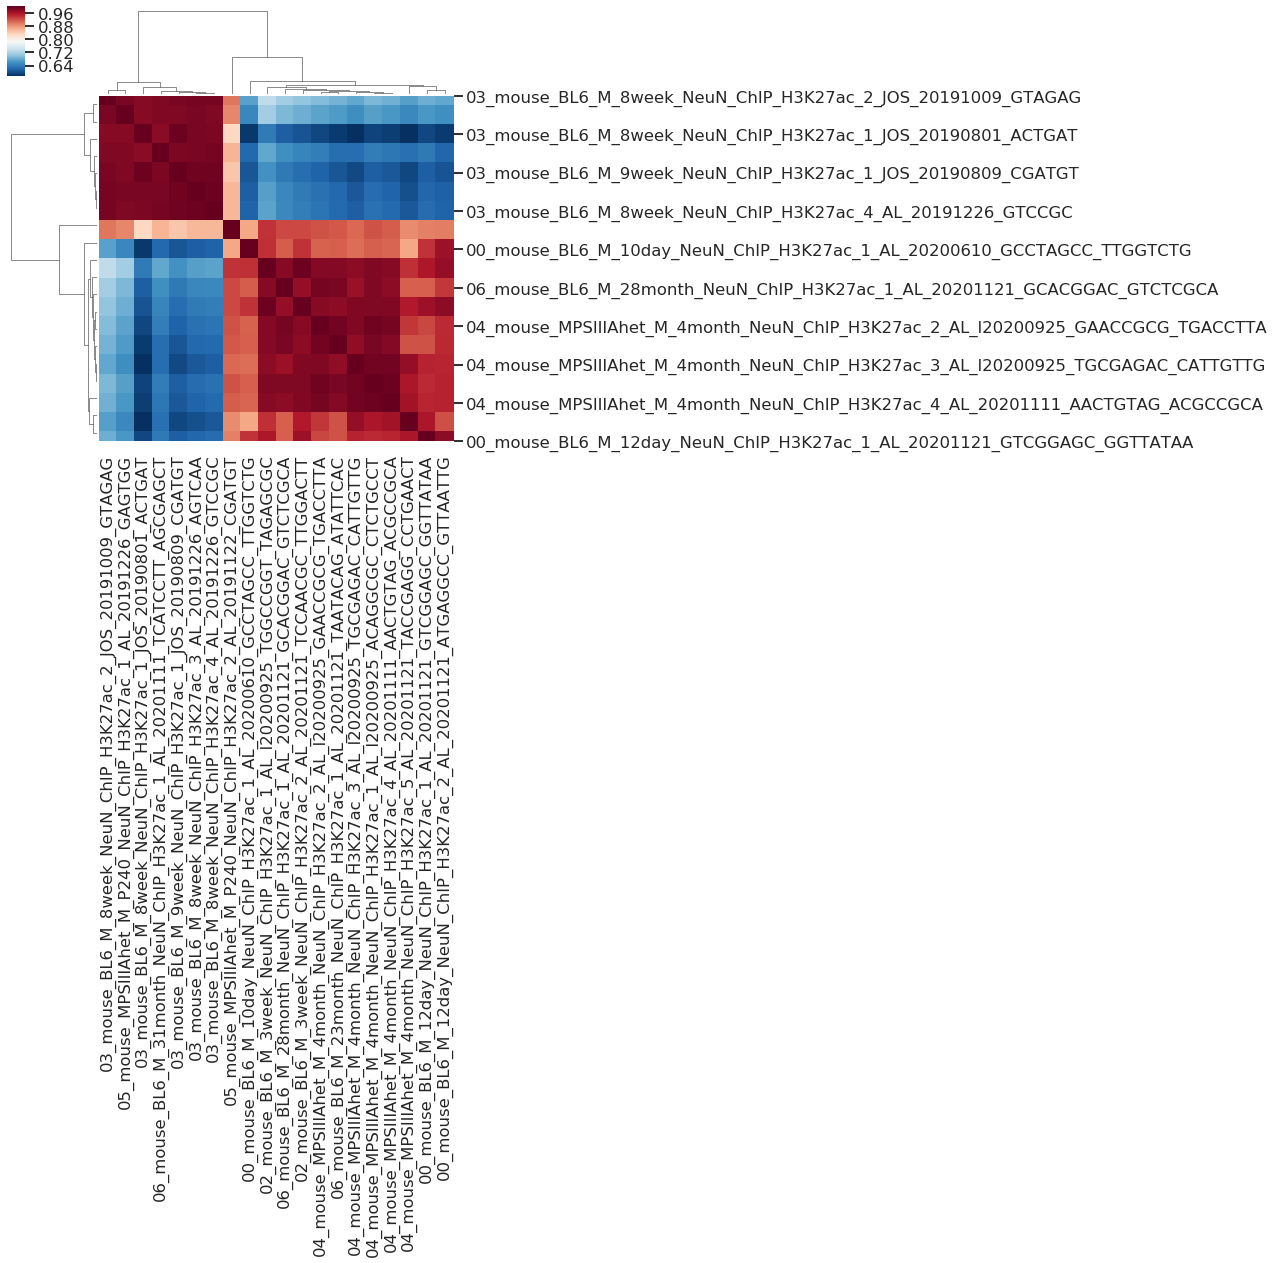

In [13]:
cm = sns.clustermap(
    mat_distal.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_distal.png', bbox_inches='tight')

### Distal peaks

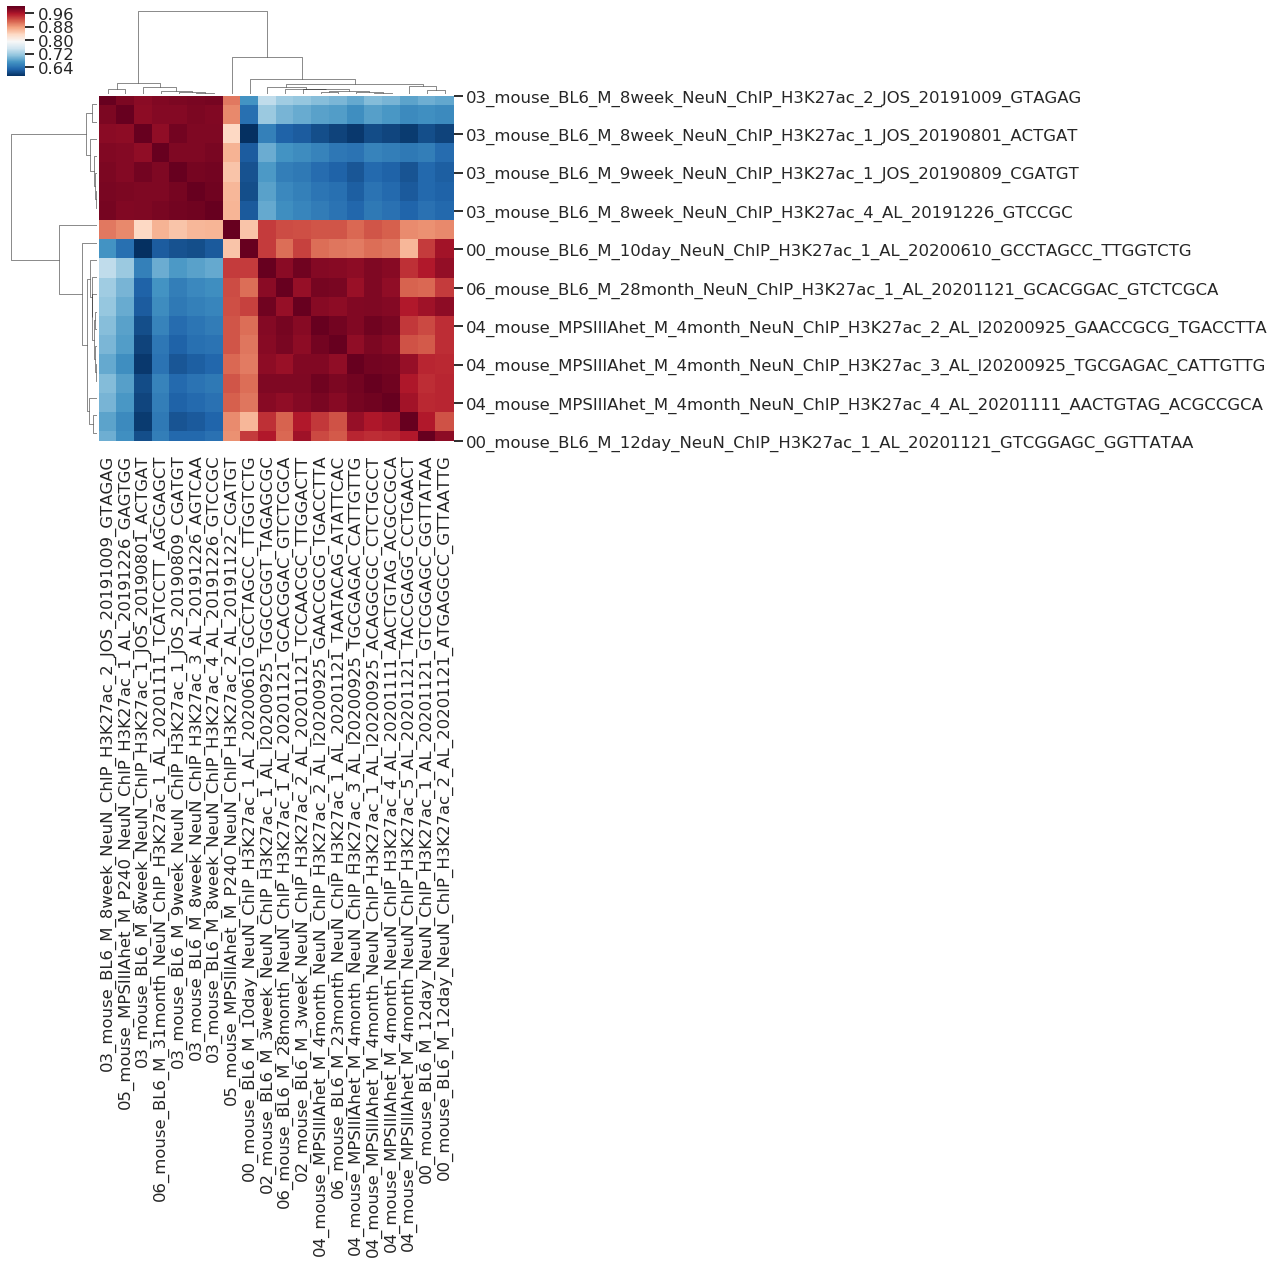

In [14]:
cm = sns.clustermap(
    mat_quant.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

## Principal Component Analysis

Create sample ID data frame for ease of plotting

In [15]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns)
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[2]
gender = samples.str.split('_').str[3]
age = samples.str.split('_').str[4]
cell = samples.str.split('_').str[5]
rep = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[9]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(gender),
                          pd.Series(age),
                          pd.Series(cell),
                          pd.Series(rep),
                          pd.Series(sampledate)],
                         index=['mouse',
                                'group',
                                'strain',
                                'gender',
                                'age',
                                'celltype',
                                'rep',
                                'sample_date']).T

### Normalized data, all peaks

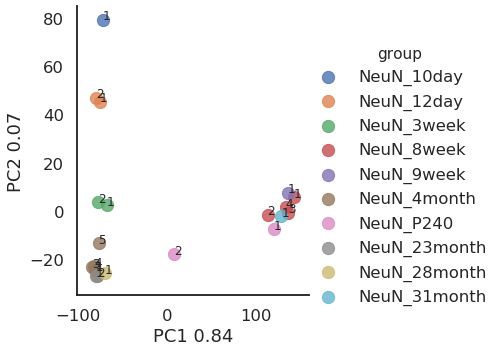

In [17]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2.png', bbox_inches='tight')

### Quantile normalized data - all peaks

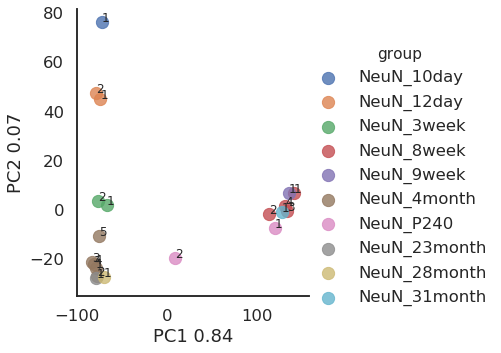

In [18]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_quantnorm_pca1_pca2.png', bbox_inches='tight')

### Distal peaks

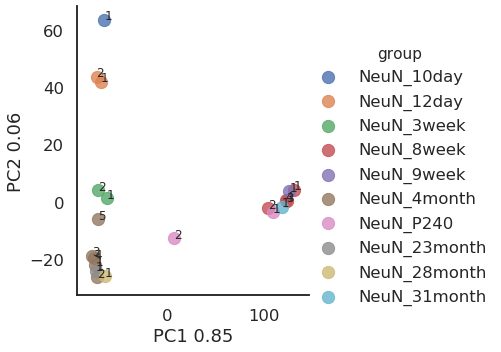

In [19]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_distal_pca1_pca2.png', bbox_inches='tight')

Unclear what is driving the difference between these 4 NeuN samples and the rest... could we be worth trying to filter them all out - although we would lose the 8 week time point. the other samples seem to largely cluster on age!

# Repeat with samples filtered based on IP efficiency

In [79]:
# import annotation file
df, mat = read_annotated_peaks('./annotated_peaks/ann_norm_vw_peaks_merged.txt')

# # try with dropped sample
dropsamp = ['03_mouse_BL6_M_8week_NeuN_ChIP_H3K27ac_1_JOS_20190801_ACTGAT',
            '03_mouse_BL6_M_8week_NeuN_ChIP_H3K27ac_2_JOS_20191009_GTAGAG',
            '03_mouse_BL6_M_8week_NeuN_ChIP_H3K27ac_3_AL_20191226_AGTCAA',
            '03_mouse_BL6_M_8week_NeuN_ChIP_H3K27ac_4_AL_20191226_GTCCGC',
            '03_mouse_BL6_M_9week_NeuN_ChIP_H3K27ac_1_JOS_20190809_CGATGT',
            '05_mouse_MPSIIIAhet_M_P240_NeuN_ChIP_H3K27ac_1_AL_20191226_GAGTGG',
            '05_mouse_MPSIIIAhet_M_P240_NeuN_ChIP_H3K27ac_2_AL_20191122_CGATGT',
            '06_mouse_BL6_M_31month_NeuN_ChIP_H3K27ac_1_AL_20201111_TCATCCTT_AGCGAGCT']

drop_files = mat.columns[mat.columns.str.contains('|'.join(dropsamp))]

df = df.drop(drop_files, axis=1)
mat = mat.drop(drop_files, axis=1)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

In [80]:
thresh = 16

print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
mat = mat.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

75485 total peaks
filtering low tag count peaks
59878 total peaks


## Mean variance plot

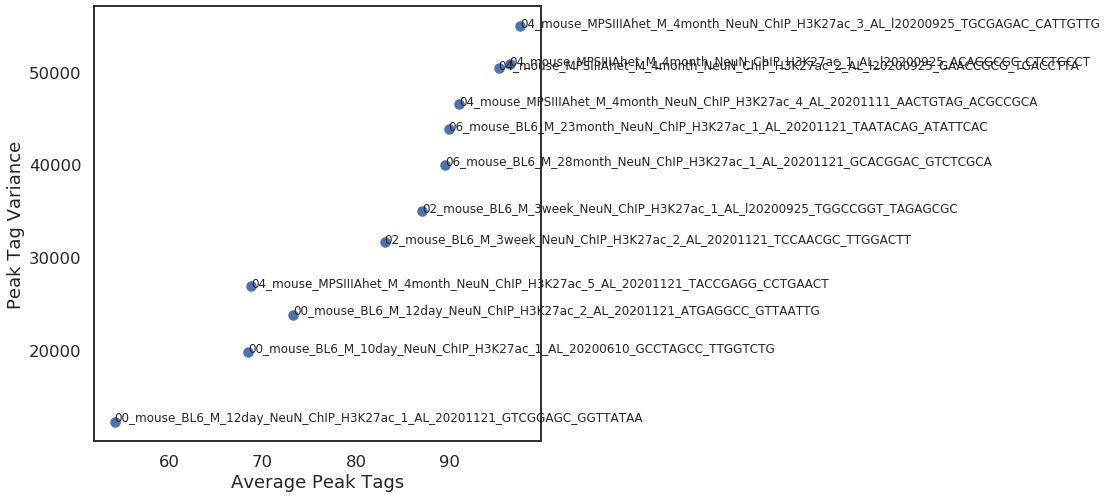

In [81]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_samples_filtered.png', bbox_inches='tight')

### Try with quantile normalized data

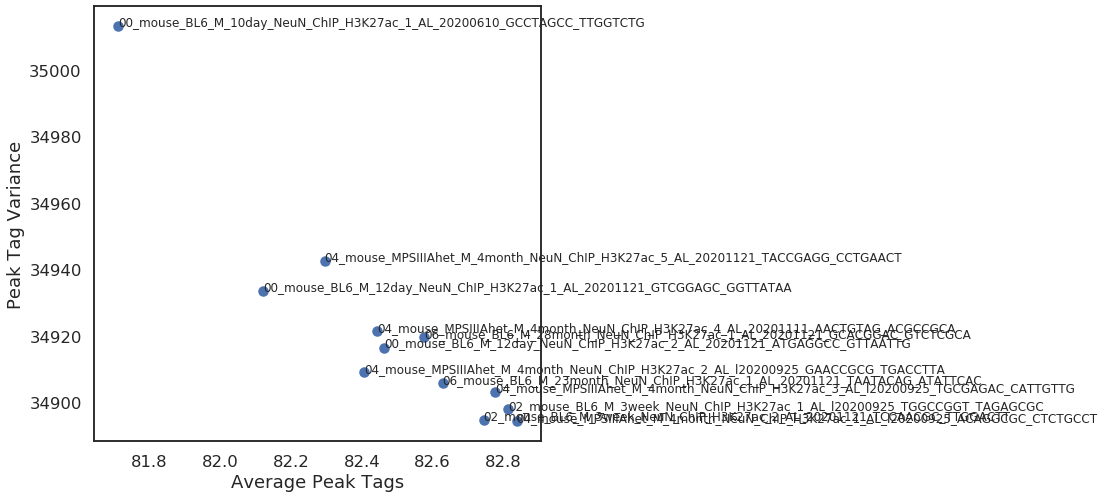

In [82]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm_samples_filtered.png', bbox_inches='tight')

## Correlation heatmap

In [83]:
mat.columns = mat.columns.str.split('/').str[-1]
mat_quant.columns = mat_quant.columns.str.split('/').str[-1]
mat_distal.columns = mat_distal.columns.str.split('/').str[-1]

### Normalized data, all peaks

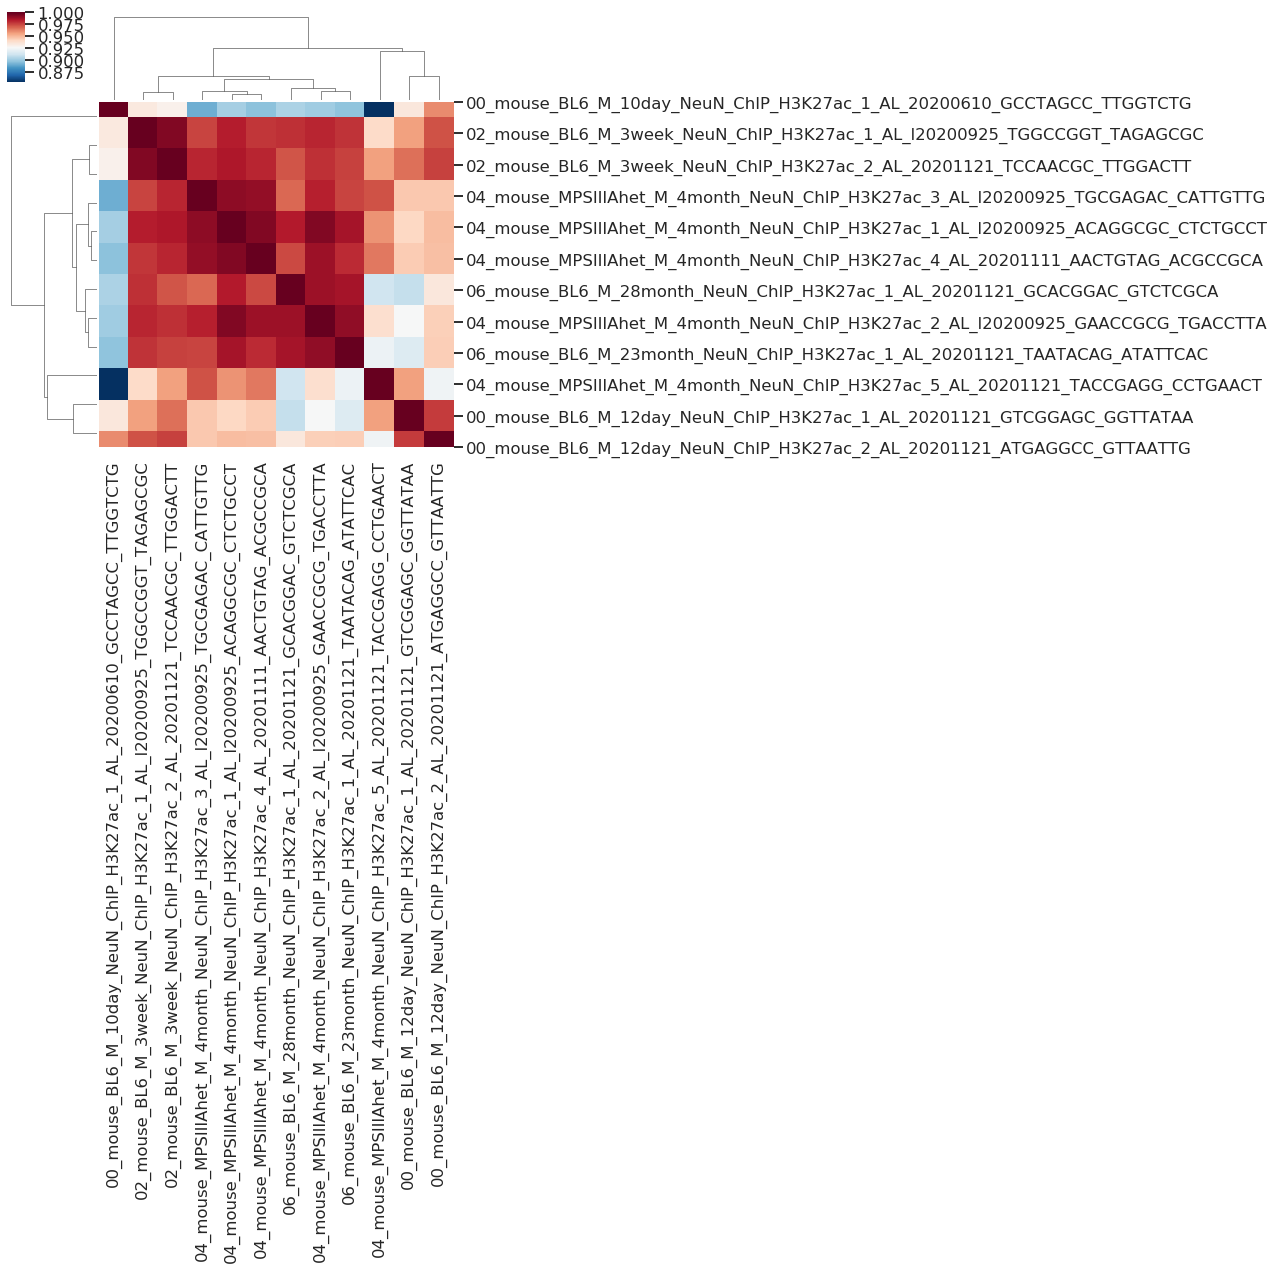

In [84]:
cm = sns.clustermap(
    mat.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_samples_filtered.png', bbox_inches='tight')

### Quantile normalized data - all peaks

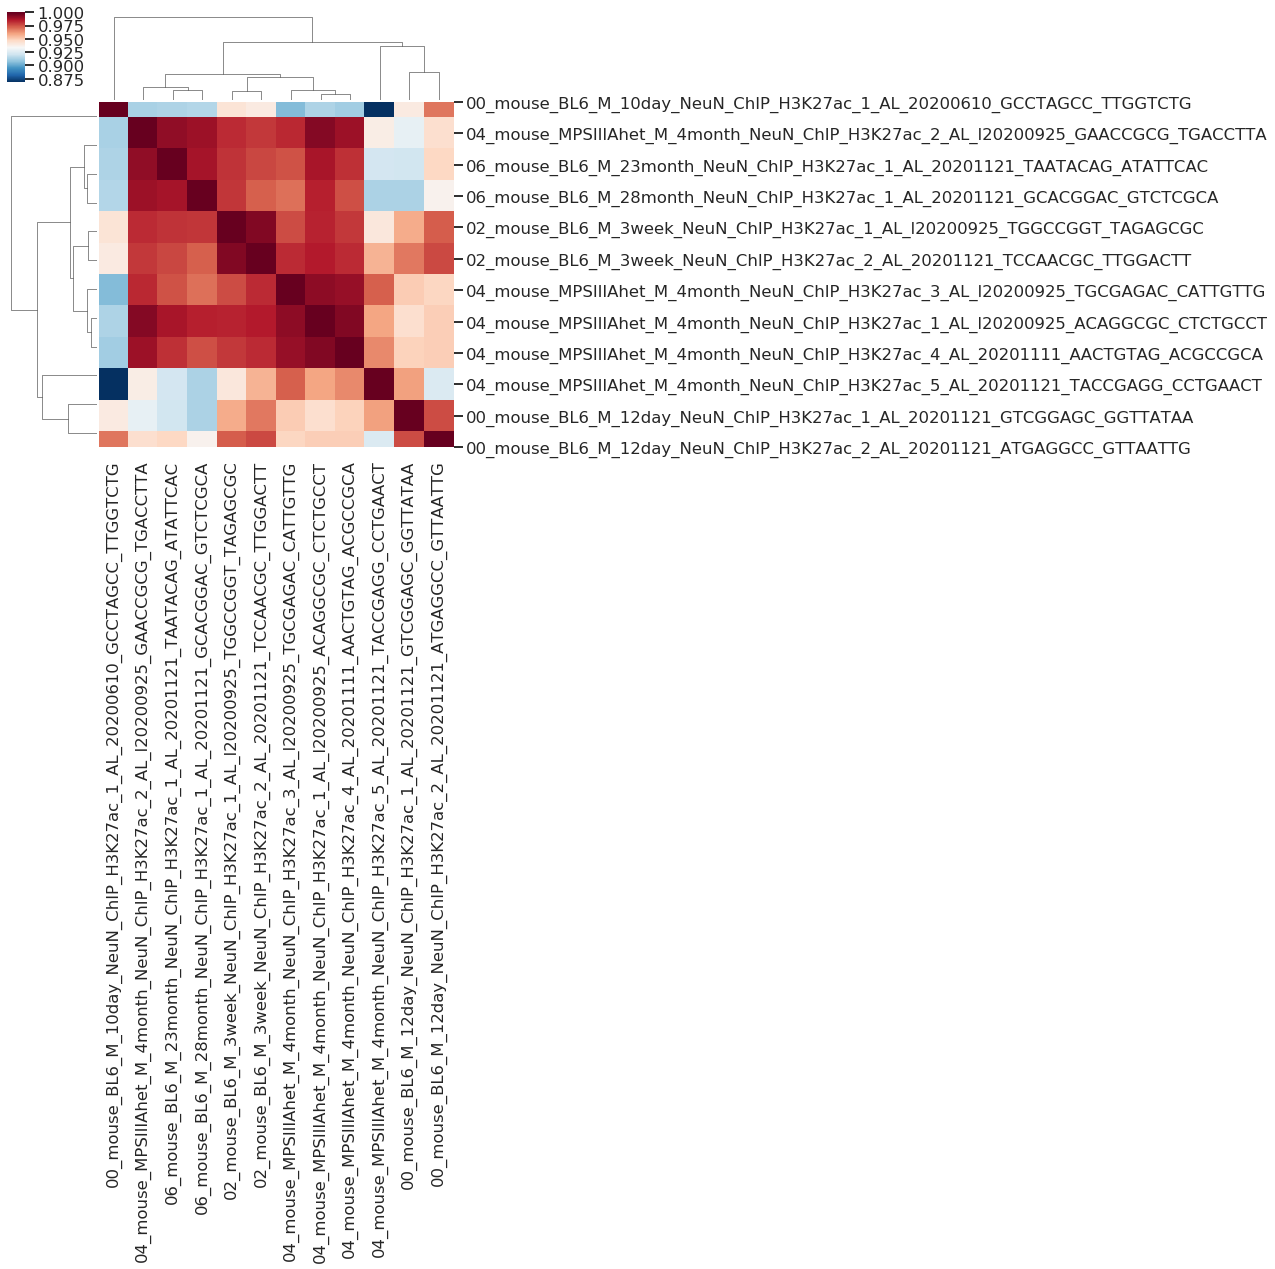

In [85]:
cm = sns.clustermap(
    mat_distal.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_distal_samples_filtered.png', bbox_inches='tight')

### Distal peaks

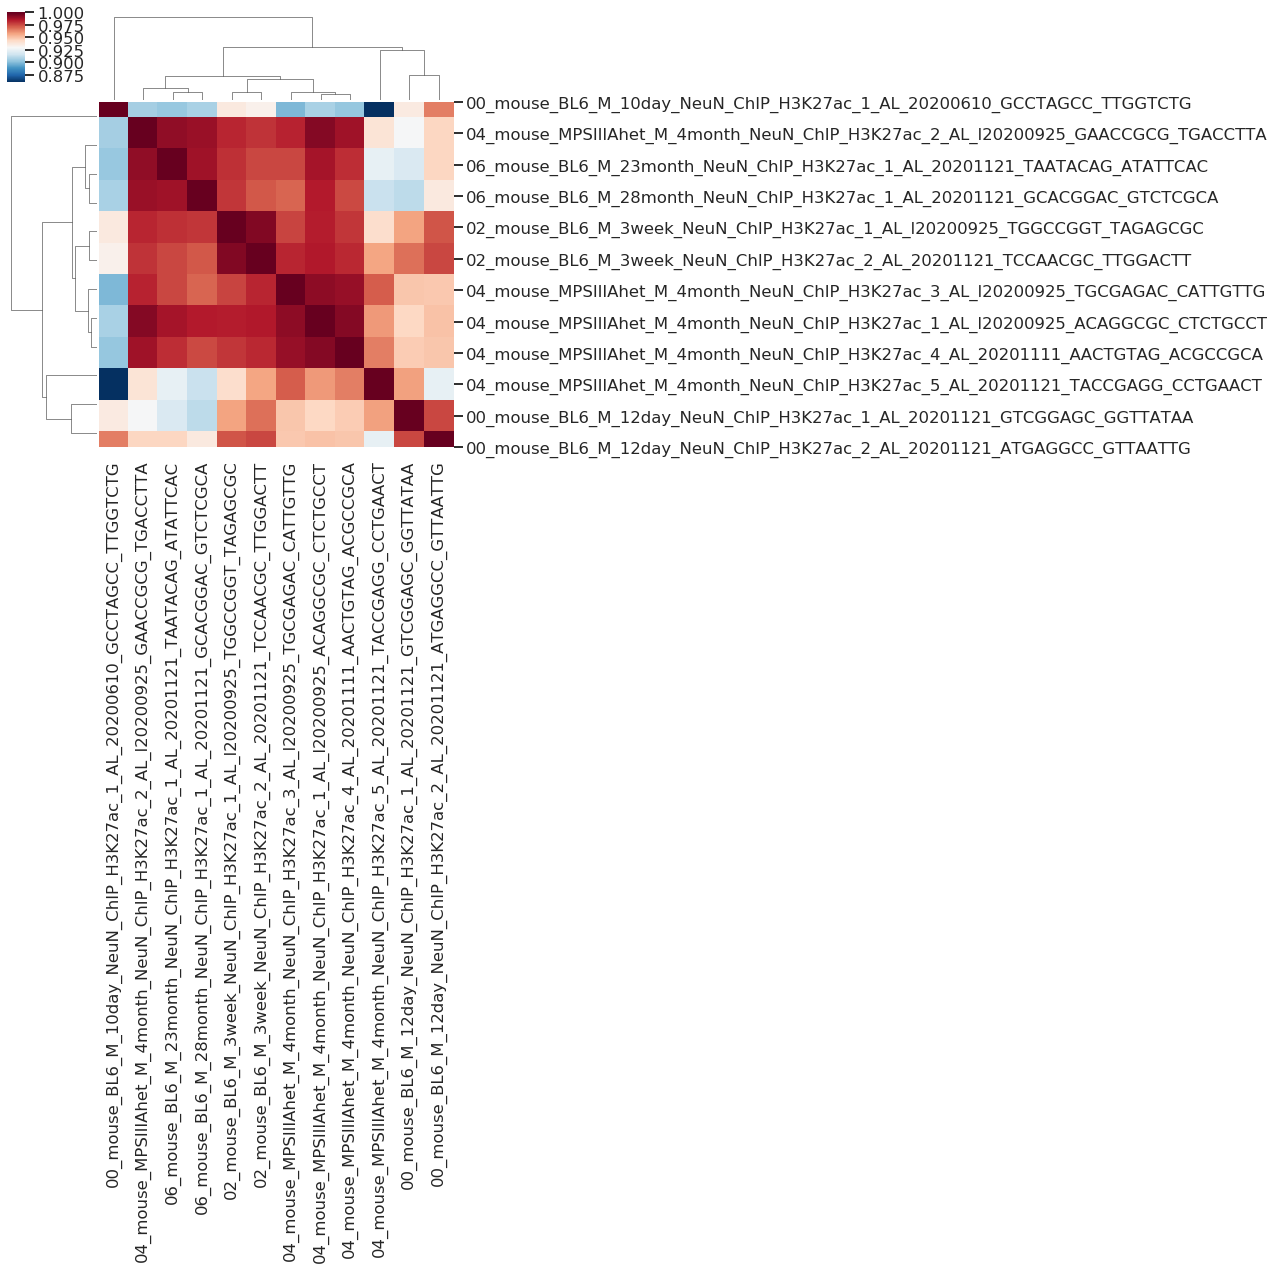

In [86]:
cm = sns.clustermap(
    mat_quant.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_quantnorm_samples_filtered.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [87]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns)
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[2]
gender = samples.str.split('_').str[3]
age = samples.str.split('_').str[4]
cell = samples.str.split('_').str[5]
rep = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[9]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(gender),
                          pd.Series(age),
                          pd.Series(cell),
                          pd.Series(rep),
                          pd.Series(sampledate)],
                         index=['mouse',
                                'group',
                                'strain',
                                'gender',
                                'age',
                                'celltype',
                                'rep',
                                'sample_date']).T

### Normalized data, all peaks

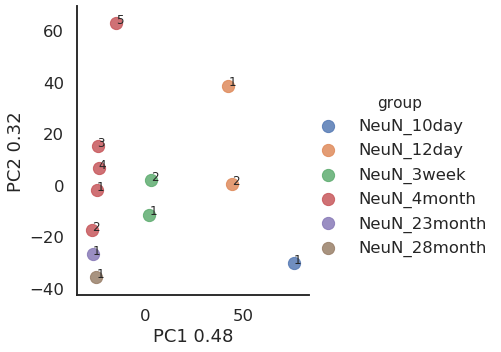

In [89]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2_samples_filtered.png', bbox_inches='tight')

### Quantile normalized data - all peaks

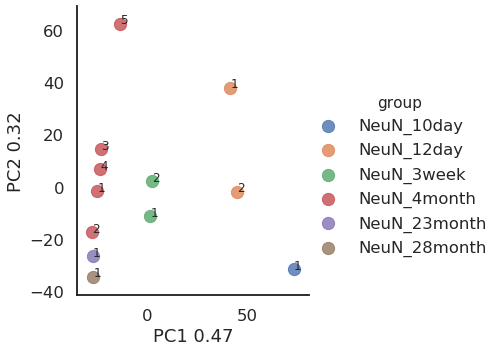

In [90]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_quantnorm_pca1_pca2_samples_filtered.png', bbox_inches='tight')

### Distal peaks

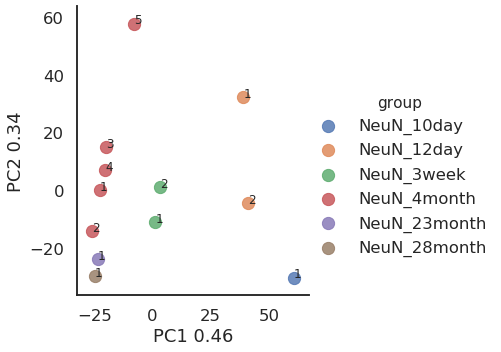

In [91]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_distal_pca1_pca2_samples_filtered.png', bbox_inches='tight')

# Merge high quality tag directories for visualization on browser

In [94]:
if not os.path.isdir('./merged_tagdirs/'):
    os.mkdir('./merged_tagdirs/')

In [ ]:
%%bash

makeTagDirectory ./merged_tagdirs/00_NeuN_2WeekOrLess_ChIP_H3K27Ac_merged -d \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/00_mouse_BL6_M_10day_NeuN_ChIP_H3K27ac_1_AL_20200610_GCCTAGCC_TTGGTCTG \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/00_mouse_BL6_M_12day_NeuN_ChIP_H3K27ac_1_AL_20201121_GTCGGAGC_GGTTATAA \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/00_mouse_BL6_M_12day_NeuN_ChIP_H3K27ac_2_AL_20201121_ATGAGGCC_GTTAATTG

makeTagDirectory ./merged_tagdirs/02_NeuN_P21_ChIP_H3K27Ac_merged -d \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/02_mouse_BL6_M_3week_NeuN_ChIP_H3K27ac_1_AL_l20200925_TGGCCGGT_TAGAGCGC \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/02_mouse_BL6_M_3week_NeuN_ChIP_H3K27ac_2_AL_20201121_TCCAACGC_TTGGACTT 

makeTagDirectory ./merged_tagdirs/03_NeuN_8week_ChIP_H3K27Ac_merged -d \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/03_mouse_BL6_M_8week_NeuN_ChIP_H3K27ac_2_JOS_20191009_GTAGAG \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/03_mouse_BL6_M_8week_NeuN_ChIP_H3K27ac_4_AL_20191226_GTCCGC \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/03_mouse_BL6_M_9week_NeuN_ChIP_H3K27ac_1_JOS_20190809_CGATGT 

makeTagDirectory ./merged_tagdirs/04_NeuN_4Month_ChIP_H3K27Ac_merged -d \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_1_AL_l20200925_ACAGGCGC_CTCTGCCT \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_2_AL_l20200925_GAACCGCG_TGACCTTA \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_3_AL_l20200925_TGCGAGAC_CATTGTTG \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_4_AL_20201111_AACTGTAG_ACGCCGCA \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_5_AL_20201121_TACCGAGG_CCTGAACT

makeTagDirectory ./merged_tagdirs/06_NeuN_20MonthPlus_ChIP_H3K27Ac_merged -d \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/06_mouse_BL6_M_23month_NeuN_ChIP_H3K27ac_1_AL_20201121_TAATACAG_ATATTCAC \
/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/06_mouse_BL6_M_28month_NeuN_ChIP_H3K27ac_1_AL_20201121_GCACGGAC_GTCTCGCA

In [93]:
%%bash

makeMultiWigHub.pl hrb_BrainAging_Viz_NeuN_H3K27Ac mm10 \
-gradient 252,187,161 222,45,38 \
-force -d \
./merged_tagdirs/00_NeuN_2WeekOrLess_ChIP_H3K27Ac_merged/ \
./merged_tagdirs/02_NeuN_P21_ChIP_H3K27Ac_merged \
./merged_tagdirs/03_NeuN_8week_ChIP_H3K27Ac_merged \
./merged_tagdirs/04_NeuN_4Month_ChIP_H3K27Ac_merged \
./merged_tagdirs/06_NeuN_20MonthPlus_ChIP_H3K27Ac_merged 

'/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/'

# Scatter plot comparison of average peak tag counts
____
This is a useful step to assess the difference between tag directories before using DESeq2. DESeq2 runs its own normalization protocol - mainly mean-variance stabilizing based on gene length, but this is somewhat opaque. Here we can just take a look at the difference that quantile normalization makes in the scatter plots of peak tag counts for each group, and check whether the tag counts for a given subgroup are particularly low or high in comparison to another.

In [48]:
for i, col in zip(range(len(mat.columns)), mat.columns):
    print(str(i)+': '+col)

0: 00_mouse_BL6_M_10day_NeuN_ChIP_H3K27ac_1_AL_20200610_GCCTAGCC_TTGGTCTG
1: 00_mouse_BL6_M_12day_NeuN_ChIP_H3K27ac_1_AL_20201121_GTCGGAGC_GGTTATAA
2: 00_mouse_BL6_M_12day_NeuN_ChIP_H3K27ac_2_AL_20201121_ATGAGGCC_GTTAATTG
3: 02_mouse_BL6_M_3week_NeuN_ChIP_H3K27ac_1_AL_l20200925_TGGCCGGT_TAGAGCGC
4: 02_mouse_BL6_M_3week_NeuN_ChIP_H3K27ac_2_AL_20201121_TCCAACGC_TTGGACTT
5: 03_mouse_BL6_M_8week_NeuN_ChIP_H3K27ac_2_JOS_20191009_GTAGAG
6: 03_mouse_BL6_M_8week_NeuN_ChIP_H3K27ac_4_AL_20191226_GTCCGC
7: 03_mouse_BL6_M_9week_NeuN_ChIP_H3K27ac_1_JOS_20190809_CGATGT
8: 04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_1_AL_l20200925_ACAGGCGC_CTCTGCCT
9: 04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_2_AL_l20200925_GAACCGCG_TGACCTTA
10: 04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_3_AL_l20200925_TGCGAGAC_CATTGTTG
11: 04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_4_AL_20201111_AACTGTAG_ACGCCGCA
12: 04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_5_AL_20201121_TACCGAGG_CCTGAACT
13: 06_mouse_BL6_M_23m

## Start with un-normalized peaks

In [49]:
groups = ['14dayish', '21day', '8week', '4month', '20month+']
columns = [[0,1,2],
           [3,4],
           [5,6,7],
           [8,9,10,11,12],
           [13,14,15]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


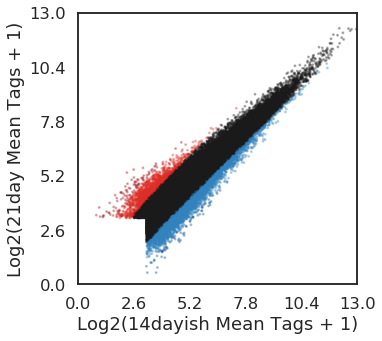

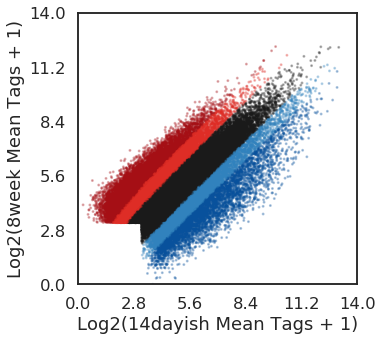

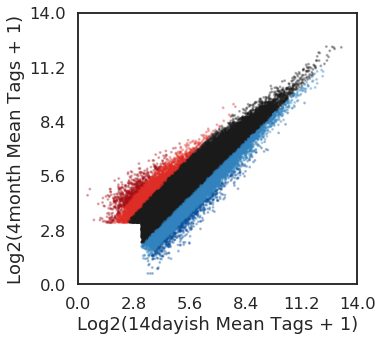

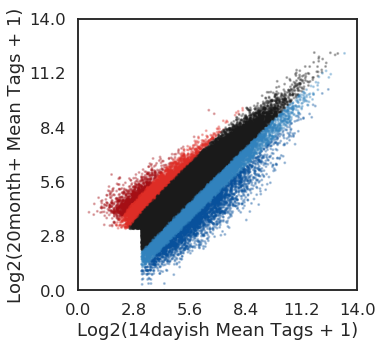

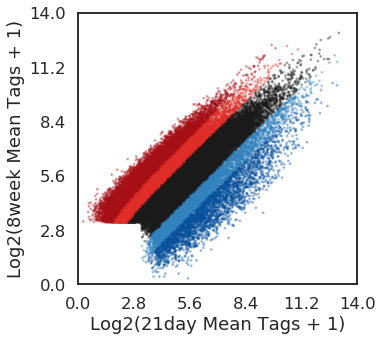

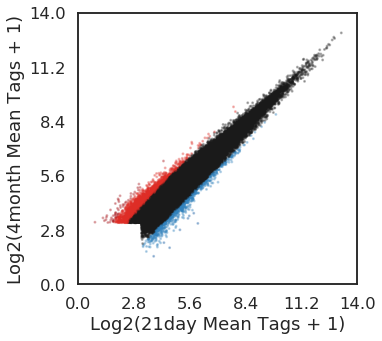

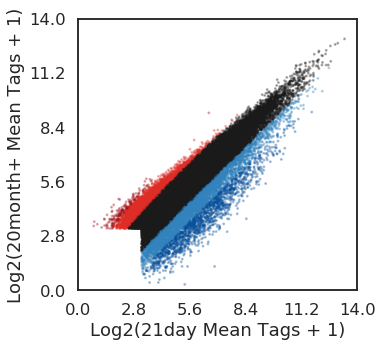

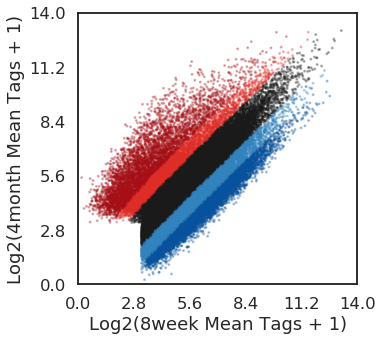

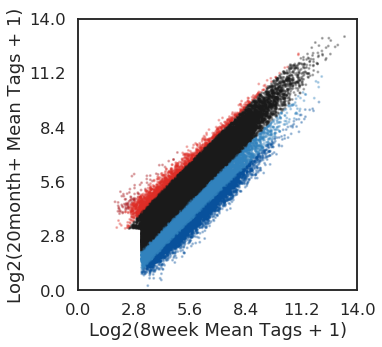

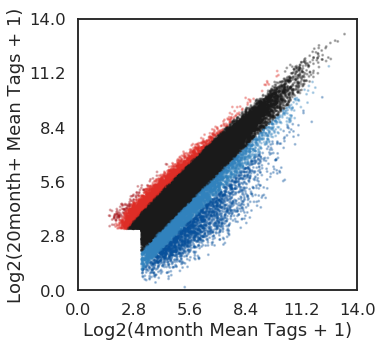

In [50]:
# set loop variables
mincount=8
thresh=[2,4]
thresh_color = {'down': ['#de2d26', '#a50f15'],
                'up': ['#3182bd', '#08519c']}
peak_count = {}

n_ticks = 5

for i, j in itertools.combinations(groups, 2):

    fig, ax = plt.subplots(figsize=(5,5))

    # filter low tag peaks
    df_tmp = avg_tags_df.loc[(avg_tags_df.loc[:, i] >= mincount) | (avg_tags_df.loc[:, j] >= mincount)]

    # set colors
    df_tmp['colors'] = 'k'
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0], 'colors'] = thresh_color['up'][0]
    peak_count['up_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0], 'colors'] = thresh_color['down'][0]
    peak_count['down_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1], 'colors'] = thresh_color['up'][1]
    peak_count['up_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1]).sum()

    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1], 'colors'] = thresh_color['down'][1]
    peak_count['down_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1]).sum()

    ax.scatter(np.log2(df_tmp.loc[:, j]+1),
               np.log2(df_tmp.loc[:, i]+1),
               s=2,
               c=df_tmp.colors,
               alpha=0.3)

    # set axis limits
    countmax = np.max([np.max(np.log2(df_tmp.loc[:, j]+1)), np.max(np.log2(df_tmp.loc[:, i]+1))])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    # fix ticks
    ax.set_xticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    ax.set_yticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    
    # label axes
    ax.set_xlabel('Log2(%s Mean Tags + 1)' % i)
    ax.set_ylabel('Log2(%s Mean Tags + 1)' % j)
    
    # save plot
    plt.savefig('./figures/'+i+'_'+j+'_pairwise_scatter.png', bbox_inches='tight')

## Plot Quantile normalized peaks

In [51]:
groups = ['14dayish', '21day', '8week', '4month', '20month+']
columns = [[0,1,2],
           [3,4],
           [5,6,7],
           [8,9,10,11,12],
           [13,14,15]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat_quant.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


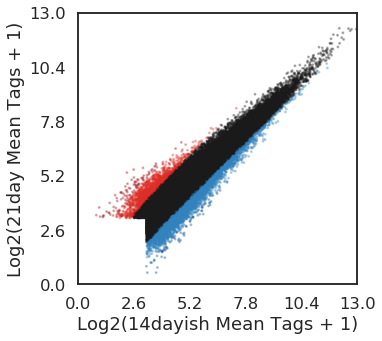

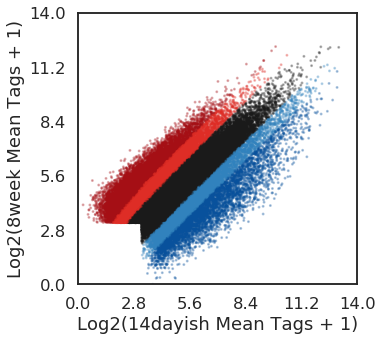

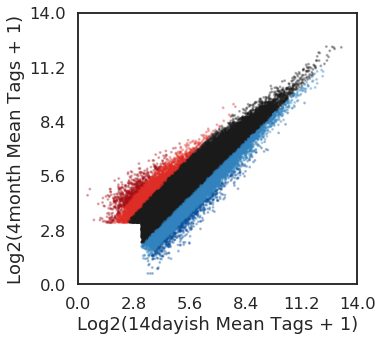

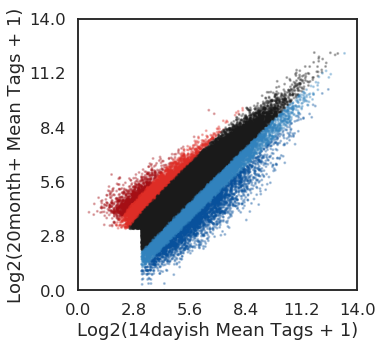

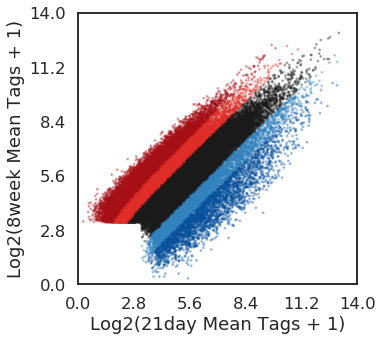

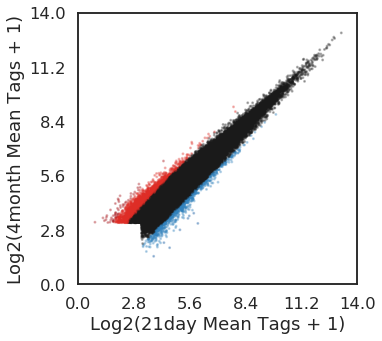

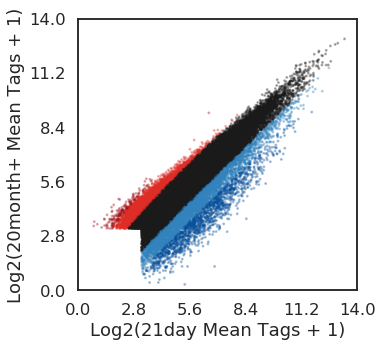

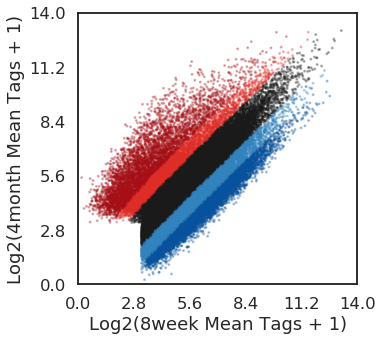

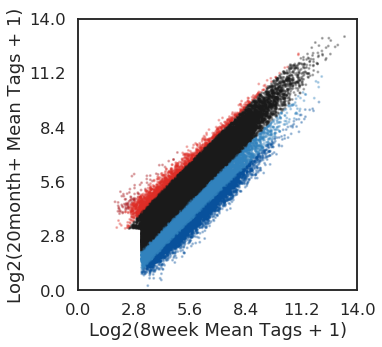

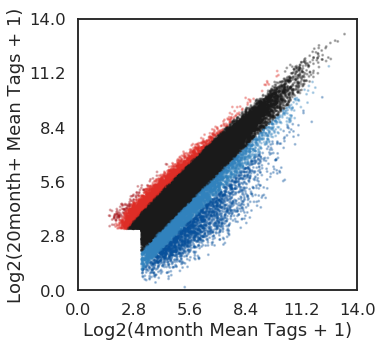

In [52]:
# set loop variables
mincount=8
thresh=[2,4]
thresh_color = {'down': ['#de2d26', '#a50f15'],
                'up': ['#3182bd', '#08519c']}
peak_count = {}

n_ticks = 5

for i, j in itertools.combinations(groups, 2):

    fig, ax = plt.subplots(figsize=(5,5))

    # filter low tag peaks
    df_tmp = avg_tags_df.loc[(avg_tags_df.loc[:, i] >= mincount) | (avg_tags_df.loc[:, j] >= mincount)]

    # set colors
    df_tmp['colors'] = 'k'
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0], 'colors'] = thresh_color['up'][0]
    peak_count['up_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0], 'colors'] = thresh_color['down'][0]
    peak_count['down_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1], 'colors'] = thresh_color['up'][1]
    peak_count['up_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1]).sum()

    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1], 'colors'] = thresh_color['down'][1]
    peak_count['down_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1]).sum()

    ax.scatter(np.log2(df_tmp.loc[:, j]+1),
               np.log2(df_tmp.loc[:, i]+1),
               s=2,
               c=df_tmp.colors,
               alpha=0.3)

    # set axis limits
    countmax = np.max([np.max(np.log2(df_tmp.loc[:, j]+1)), np.max(np.log2(df_tmp.loc[:, i]+1))])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    # fix ticks
    ax.set_xticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    ax.set_yticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    
    # label axes
    ax.set_xlabel('Log2(%s Mean Tags + 1)' % i)
    ax.set_ylabel('Log2(%s Mean Tags + 1)' % j)
    
    # save plot
    plt.savefig('./figures/'+i+'_'+j+'_pairwise_quantnorm_scatter.png', bbox_inches='tight')